In [1]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import os
import re




In [2]:
current_dir = os.getcwd()


#just a quick verif to check whether the file exist in the current directory and whether the current directory itself exist
if len(current_dir) != 0 and re.search(r"^C:\\",current_dir):
    print("Directory exist\n")
else:
    raise ValueError("Directory empty \n")

print(current_dir)

found = False
for i in os.listdir(current_dir):
    if i == "listings.csv":
        print("CSV file existing\n")
        found = True
        data = pd.read_csv("listings.csv")
        break

if not found:
    print("csv missing\n")
    exit(-1)

Directory exist

C:\Users\Yuan Shao\Desktop\multimodal_pro
CSV file existing



Just merely meant to tinker with the os lib

In [3]:
print(data.head(15),end="\n")
#print(data.columns,end="\n")
col = data.columns
filt = col.str.contains(r"review",regex=True)
data_filt = data.loc[:,filt].any(axis=1)
print(data.loc[data_filt].head(3),end="\n")

#let us find out about the host
print(data.columns)


         id                           listing_url       scrape_id  \
0   2719440  https://www.airbnb.com/rooms/2719440  20250912034503   
1   2721397  https://www.airbnb.com/rooms/2721397  20250912034503   
2   2726092  https://www.airbnb.com/rooms/2726092  20250912034503   
3   2726327  https://www.airbnb.com/rooms/2726327  20250912034503   
4   2727929  https://www.airbnb.com/rooms/2727929  20250912034503   
5   2729247  https://www.airbnb.com/rooms/2729247  20250912034503   
6   2732500  https://www.airbnb.com/rooms/2732500  20250912034503   
7   2733196  https://www.airbnb.com/rooms/2733196  20250912034503   
8   2735222  https://www.airbnb.com/rooms/2735222  20250912034503   
9   2738129  https://www.airbnb.com/rooms/2738129  20250912034503   
10  2808483  https://www.airbnb.com/rooms/2808483  20250912034503   
11  2808778  https://www.airbnb.com/rooms/2808778  20250912034503   
12  2810629  https://www.airbnb.com/rooms/2810629  20250912034503   
13  2813840  https://www.airbnb.co

Here we have 2 kind of data, structed (quantitative/qualitative) and unstructured(text) 

Hypothesis, we might have to resort to use models applied to numerics/categorical variables thus text mining(TF-IDF so on and so forth) 

***NOW LET US FOCUS ON THE SUPERHOST***

host_is_superhost
0.0    62568
1.0    16972
NaN     2313
Name: count, dtype: int64


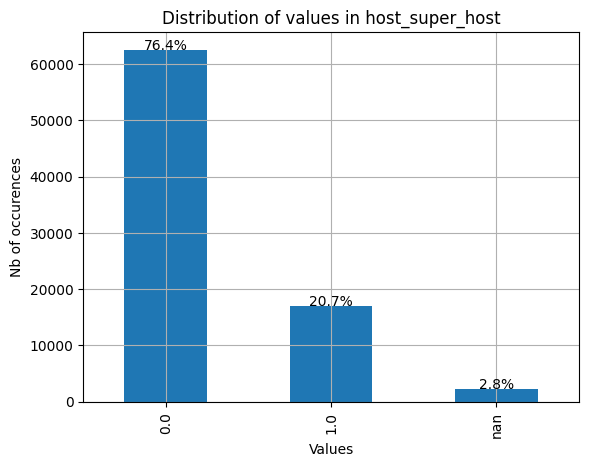

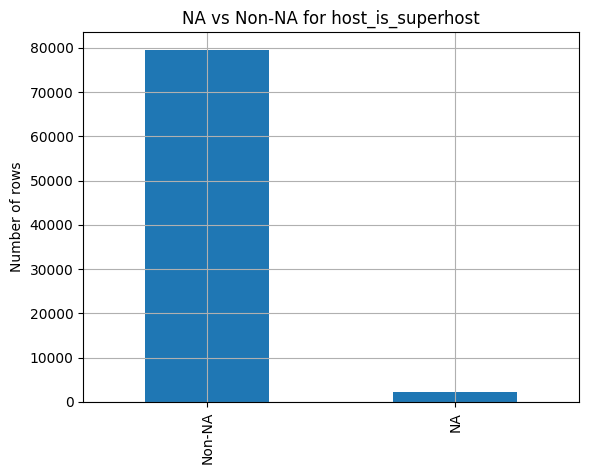

                 id     scrape_id       host_id  host_is_superhost  \
count  8.185300e+04  8.185300e+04  8.185300e+04       79540.000000   
mean   6.474769e+17  2.025091e+13  1.881639e+08           0.213377   
std    5.533184e+17  0.000000e+00  2.105173e+08           0.409694   
min    3.109000e+03  2.025091e+13  2.626000e+03           0.000000   
25%    3.124670e+07  2.025091e+13  1.932200e+07           0.000000   
50%    8.417510e+17  2.025091e+13  7.426650e+07           0.000000   
75%    1.130166e+18  2.025091e+13  3.445411e+08           0.000000   
max    1.482029e+18  2.025091e+13  7.171757e+08           1.000000   

       host_listings_count  host_total_listings_count  \
count         81833.000000               81833.000000   
mean             30.160217                  39.745164   
std             116.081728                 155.466214   
min               0.000000                   0.000000   
25%               1.000000                   1.000000   
50%               1.000000 

In [4]:
data["host_is_superhost"] = data["host_is_superhost"].map({"f":0,"t":1})

distrib = data["host_is_superhost"].value_counts(dropna=False)

print(distrib)

#distribution to explore and understand more
distrib.plot(kind="bar")
plt.title("Distribution of values in host_super_host")
perc = (lambda x: (x / distrib.sum())*100)

for i,v in enumerate(distrib):
    
    plt.text(i,v,f"{perc(v):.1f}%",ha="center")
plt.xlabel("Values")
plt.ylabel("Nb of occurences")
plt.grid(True)
plt.show()

na_mask = data["host_is_superhost"].isna()

na_counts = na_mask.value_counts()
na_counts.index = ["Non-NA", "NA"]
na_counts.plot(kind="bar")
plt.title("NA vs Non-NA for host_is_superhost")
plt.ylabel("Number of rows")
plt.grid(True)
plt.show()


print(data.describe())
print(f"\n{data.dtypes.value_counts()}")

#let us retrieve numerical variables
target = "host_is_superhost"

num_col = data.select_dtypes(include=["number"]).columns.tolist()
num_col = [c for c in num_col if c != target]

quali_col = data.select_dtypes(exclude=["number"]).columns.tolist()

print(data[num_col].describe().T) #Here certain values may be counted as NAN because they are not numerically formated


***We now notice that columns ids are unique and not relevant for predictions, therefore we may remove EM***

In [5]:
data.shape
#data.drop(columns=["id","scrape_id","host_id"],axis=1,inplace=True)
print("After removal\n")
data.shape

After removal



(81853, 79)

***We notice that urls are irelevant in our case, so they are to be removed as well***

In [6]:
url_list : list = [x for x in data.columns if re.search("url",x)]
print(url_list)

['listing_url', 'picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url']


In [7]:
data.drop(columns=url_list,axis=1,inplace=True)

In [8]:
data.shape[1]

74

***looks like we got some metadata as well such as scraping columns and source***

In [9]:
scrap_l : list = [cl for cl in data.columns if re.search("scraped",cl) or re.search("source",cl)]
print(scrap_l)

['last_scraped', 'source', 'calendar_last_scraped']


In [10]:
data.drop(columns=scrap_l,axis=1,inplace=True)

In [11]:
data.shape

(81853, 71)

***I had an idea, I thought perhaps I should check for all columns containing NA and sort them by quantity of NAN VALUES***

In [12]:
na_ratio = data.isna().mean().sort_values(ascending=False)

In [13]:
na_ratio.head(20)

neighbourhood_group_cleansed    1.000000
estimated_revenue_l365d         1.000000
bathrooms                       1.000000
calendar_updated                1.000000
beds                            1.000000
price                           1.000000
host_neighbourhood              0.657948
host_about                      0.554042
neighbourhood                   0.516206
neighborhood_overview           0.516206
host_response_rate              0.393449
host_response_time              0.393449
host_acceptance_rate            0.319231
review_scores_value             0.219638
review_scores_checkin           0.219638
review_scores_location          0.219625
review_scores_accuracy          0.219552
review_scores_communication     0.219528
review_scores_cleanliness       0.219515
review_scores_rating            0.219418
dtype: float64

***We do have interesting informations here, as we can see somecolumns have 100% NANS values, therefore irrelevant informations for our predictions***

In [14]:
print(type(na_ratio))

<class 'pandas.core.series.Series'>


In [15]:
na_ratio = na_ratio[na_ratio > 0.8].index.tolist()
na_ratio

['neighbourhood_group_cleansed',
 'estimated_revenue_l365d',
 'bathrooms',
 'calendar_updated',
 'beds',
 'price']

***Surprised to notice that the price***

In [16]:
print(data["price"])
#Price contains no values, therefore it is a useless numerical value

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
81848   NaN
81849   NaN
81850   NaN
81851   NaN
81852   NaN
Name: price, Length: 81853, dtype: float64


In [17]:
data.drop(columns=na_ratio,axis=1,inplace=True)

In [18]:
data.shape

(81853, 65)

In [19]:
na_ratio = data.isna().mean().sort_values(ascending=False)
na_ratio

host_neighbourhood        0.657948
host_about                0.554042
neighbourhood             0.516206
neighborhood_overview     0.516206
host_response_rate        0.393449
                            ...   
availability_30           0.000000
maximum_nights            0.000000
maximum_nights_avg_ntm    0.000000
minimum_nights_avg_ntm    0.000000
id                        0.000000
Length: 65, dtype: float64

In [20]:
data.columns

Index(['id', 'scrape_id', 'name', 'description', 'neighborhood_overview',
       'host_id', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'amenities',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'avail

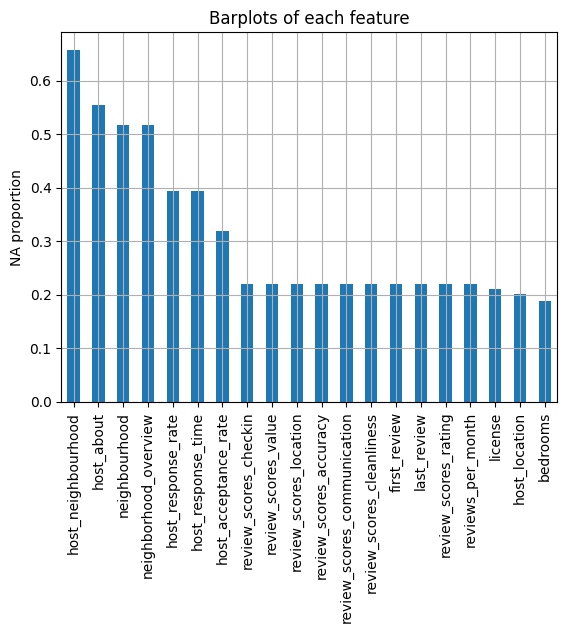

In [21]:
#Let's visualize our data
na_ratio.head(20).plot(kind="bar")
plt.ylabel("NA proportion")
plt.grid(True)
plt.title("Barplots of each feature")
plt.show()

#New Idea, ***observing numerical features to check whether we have correlations, perhaps a PCA could help us if we do see some***

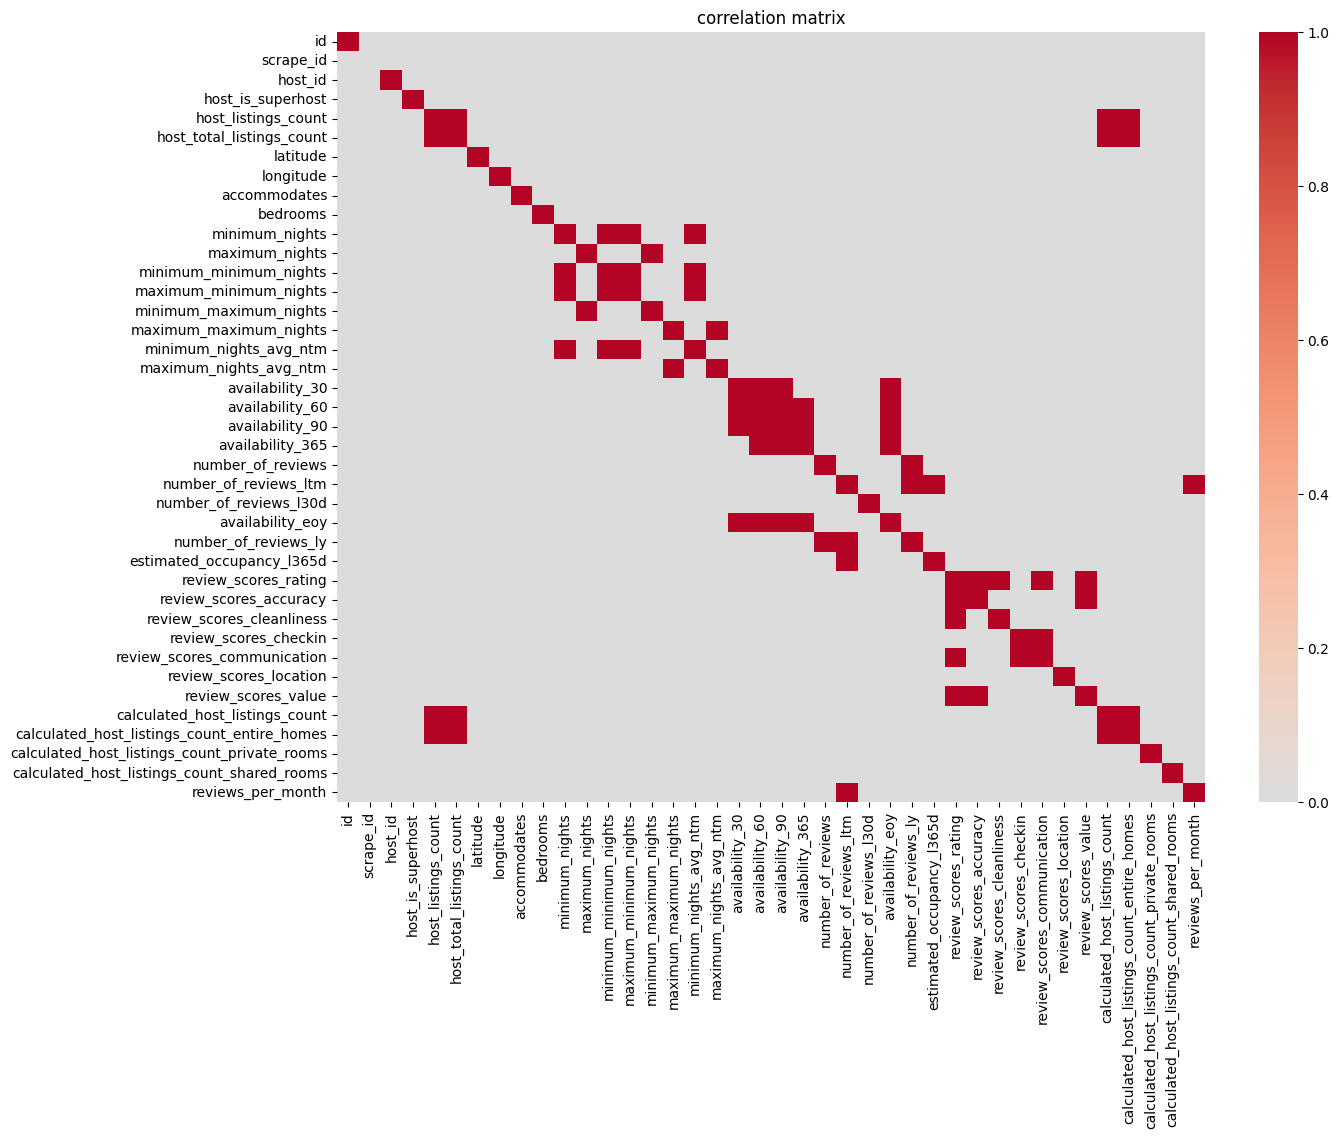

In [22]:
num = data.select_dtypes(include="number").columns
corr = data[num].corr()
strong_cor = corr > 0.7
import seaborn as sns
plt.figure(figsize=(14,10))
sns.heatmap(strong_cor,cmap="coolwarm",center=0)
plt.title("correlation matrix")
plt.show()

***The heatmap(correlation matrix) shows something interesting, several groups of variables are strongly correlated(housing availability, activity and quality)
Furthermore the rating of profesionnalism of hosts. This structure suggests the existence of commun dimmensions and colinearity between columns. Which indicates the possibility of using exploratory
techniques, such as PCA on those quantitative variables.***

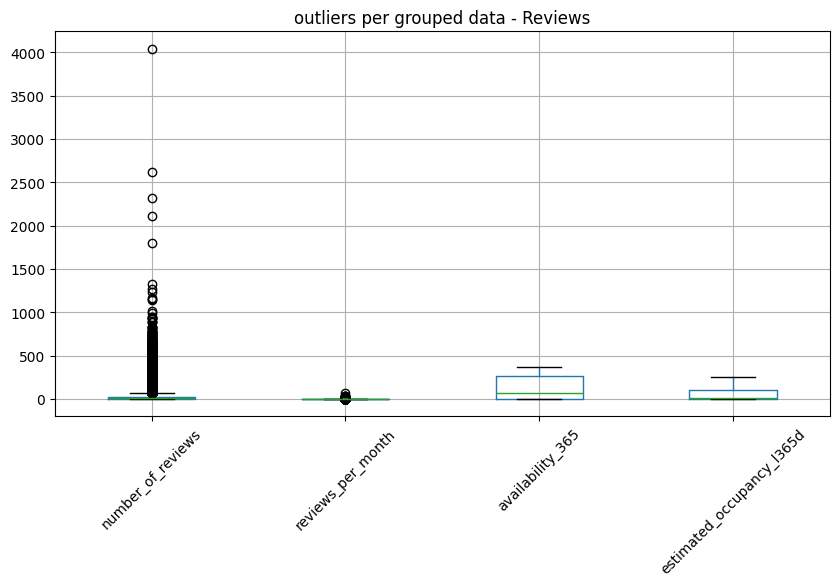

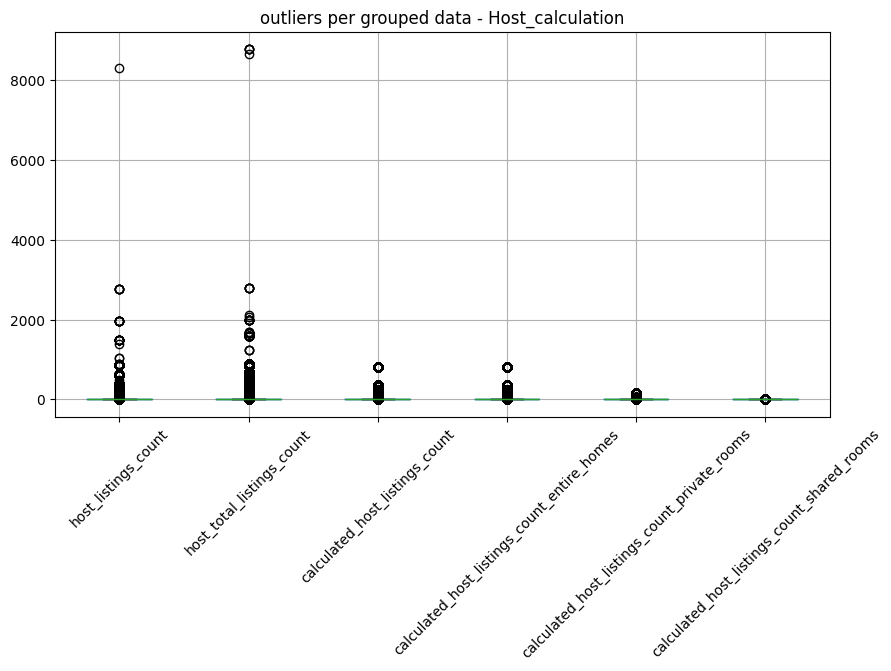

Number of NAN values in number_of_reviews

20815 outliers superior to the average

Quantiles: 0.25      1.00
0.50      7.00
0.75     28.00
0.90     69.00
0.99    293.48
Name: number_of_reviews, dtype: float64


In [23]:
#I had an idea, I shall display boxplots to understand outliers in different grouped data

activity_cols = [
    "number_of_reviews",
    "reviews_per_month",
    "availability_365",
    "estimated_occupancy_l365d"
]

host_cols = [
    "host_listings_count",
    "host_total_listings_count",
    "calculated_host_listings_count",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms"
]

group = {
    "Reviews" : activity_cols,
    "Host_calculation" : host_cols
}


for name, index in group.items():

    data[index].boxplot(figsize=(10,5),rot=45)
    plt.title(f"outliers per grouped data - {name}")
    plt.grid(True)
    plt.show()


print("Number of NAN values in number_of_reviews\n")
nb_rev_av = data["number_of_reviews"].mean()
nb = (data["number_of_reviews"] > nb_rev_av).sum()
print(f"{nb} outliers superior to the average\n")
print(f"Quantiles: {data["number_of_reviews"].quantile([0.25, 0.5, 0.75, 0.9, 0.99])}")


***Calculating the quantiles we observe interesting scenarios, around 0.01% of housing receive 293 reviews but 50% of theme receive under 7 reviews***

***IMPORTANT TO KEEP IN MIND***

1- Several numerical variables can be grouped into a family corresponding to housing,quality,availability so on and so forth.

2- Distributions are strongly asymetric

3- Several NAN variables in columns are important informations to take into account, they reflect the abscence of history or activity for certain hosts. Therefore still relevant

4- Last but not least, data found in text, indicate communication and relevant informations regarding the quality of the host

***Let us explore comments***

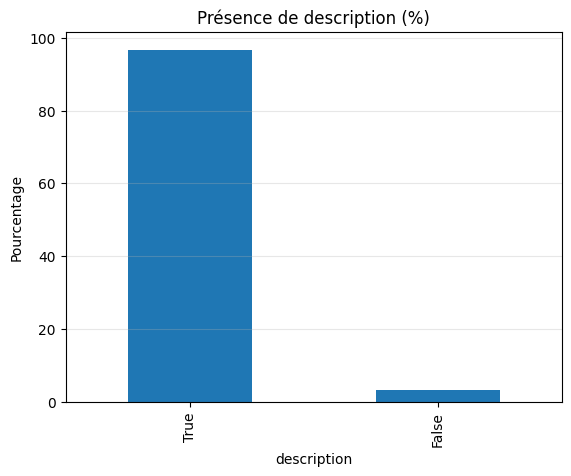

In [24]:
text_present = (data["description"].str.len() > 0)

distrib = text_present.value_counts(normalize=True) * 100

distrib.plot(kind="bar")
plt.title("description presence(%)")
plt.ylabel("Percentage")
plt.grid(axis="y", alpha=0.3)
plt.show()


***Let us operate on the comments and fill the NA with empty text***

In [25]:
data["description"] = data["description"].fillna("")
emp_ratio = (data["description"].str.len() == 0).mean()
print(f"Ratio of empty comments{emp_ratio}\n")

Ratio of empty comments0.03314478394194471



In [26]:
#let us count the number of words
data["length_of_words"] = data["description"].str.split().apply(len)
data["length_of_words"].describe()
data.groupby("host_is_superhost")["length_of_words"].mean()

host_is_superhost
0.0    55.436629
1.0    60.919632
Name: length_of_words, dtype: float64

***TRULY interesting results !***
It seems that the proportion of words for good/bad host is relatively the same, but again some comments or missing but host_is_supperhost is missing a lot of values

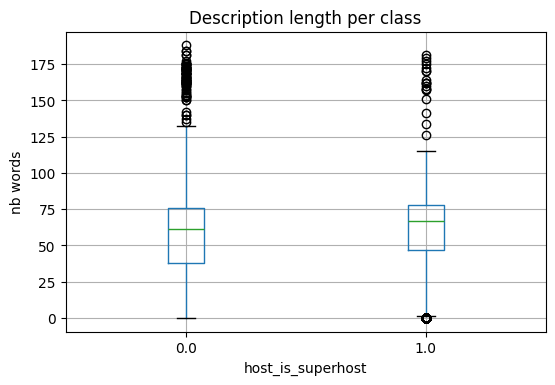

In [27]:
data.boxplot(column="length_of_words",by="host_is_superhost",figsize=(6,4))
plt.title("Description length per class")
plt.suptitle("")
plt.ylabel("nb words")
plt.grid(True)
plt.show()

***A LOT OF OUTLIERS and the median between good and bad host are almost the same, but the mean of super host seems higher, displaying an effort of the user to speak***

In [28]:
print("for superhost ")
print(data.loc[data["host_is_superhost"] == 1, "description"].head(2))

print("\n for non superhost")
print(data.loc[data["host_is_superhost"] == 0, "description"].head(2))


for superhost 
1    In the heart of historical Paris le Marais, gr...
5    Experience luxury on the 6th floor with elevat...
Name: description, dtype: object

 for non superhost
0    This beautiful apartment is very well located ...
2    A stone's throw from Parc Monceau and the Arc ...
Name: description, dtype: object


***The exploration of textual descriptions shows that text is widely available and that its length differs according to Superhost status. Descriptions written by Superhosts tend to be longer and more structured, suggesting a greater communication effort. This indicates that textual data provides complementary qualitative information to tabular variables. These observations motivate the training of a dedicated unimodal model for textual data in the modeling phase.***

***3.2 INTRODUCTION***
We now have a clear understanding of what to do with our data, distinct unimodels for tabular data text(TF-IDF), and pre treatmen(normalization,missing values balancing, and hot encoding of categorical variables)


In [29]:
#first I shall train models on numerical/categorical features before moving on onto textual data(tf-idf bag-of-words

#target column host_is_superhost
target = "host_is_superhost"

data_use = data[data[target].notna()] #I only use the not na variables
print(data_use)



                        id       scrape_id  \
0                  2719440  20250912034503   
1                  2721397  20250912034503   
2                  2726092  20250912034503   
3                  2726327  20250912034503   
4                  2727929  20250912034503   
...                    ...             ...   
81847  1481750447988124216  20250912034503   
81848  1481754230424845668  20250912034503   
81849  1481771421372168466  20250912034503   
81851  1481814132906153972  20250912034503   
81852  1481829796903012005  20250912034503   

                                                    name  \
0                        Nice flat close to Montparnasse   
1                     Marais - Charming loft, river view   
2                      Superbe 2 pièces idéalement placé   
3         Cozy place, Sacré Coeur Montmartre in the SoPi   
4                  Appartement d'architecte - Montmartre   
...                                                  ...   
81847  BM-Cocon citadin, qu

In [30]:
!py -m pip install scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
#now let us start splitting our data before imputing

X = data_use.drop(columns=[target])
y = data_use[target]

print(data.shape,end="\n")
print(y)

from sklearn.model_selection import train_test_split


text_cols = [
    "name", "description", "neighborhood_overview",
    "host_about", "amenities"
]

url_cols = [
    "listing_url", "picture_url", "host_url",
    "host_thumbnail_url", "host_picture_url"
]

date_cols = [
    "last_scraped", "calendar_last_scraped",
    "first_review", "last_review"
]

X = X.drop(columns=text_cols + url_cols + date_cols, errors="ignore")

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()

print(X.shape,end="\n")

X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)


(81853, 66)
0        0.0
1        1.0
2        0.0
3        0.0
4        0.0
        ... 
81847    0.0
81848    1.0
81849    0.0
81851    1.0
81852    0.0
Name: host_is_superhost, Length: 79540, dtype: float64
(79540, 58)


              precision    recall  f1-score   support

         0.0       0.97      0.88      0.92     12514
         1.0       0.67      0.89      0.76      3394

    accuracy                           0.88     15908
   macro avg       0.82      0.88      0.84     15908
weighted avg       0.90      0.88      0.89     15908

ROC_AUC:  0.9508957745757279
[[11032  1482]
 [  384  3010]]


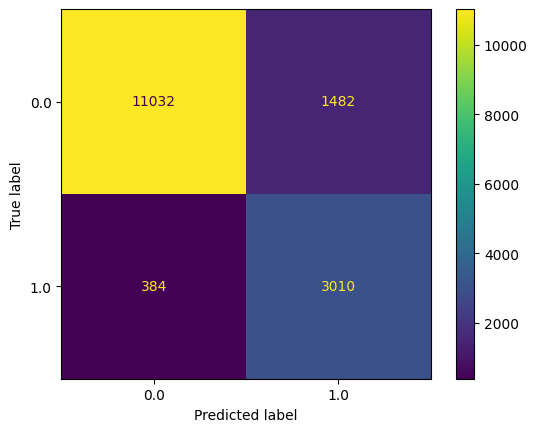

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#create the pipeline to impute

num_pipeline = Pipeline(steps=[
    ("Imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ("Imputer",SimpleImputer(strategy="constant",fill_value="missing")),
    ("onehot",OneHotEncoder(handle_unknown="ignore"))
    ])
#pipeline defined, now we can create preprocessor

prepro = ColumnTransformer(transformers=[
    ("num",num_pipeline,num_cols),
    ("cat",cat_pipeline,cat_cols)
])


from sklearn.linear_model import LogisticRegression

log_reg = Pipeline(steps=[
    ("preprocess",prepro),
    ("model",LogisticRegression(max_iter=1000,class_weight="balanced",random_state=42))
])

#the pipeline is done, the data are splitted
log_reg.fit(X_train,y_train)

from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix, ConfusionMatrixDisplay

y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:,1]

print(classification_report(y_test,y_pred))
print(f"ROC_AUC: ",roc_auc_score(y_test,y_proba))
print(confusion_matrix(y_test,y_pred))

cm = confusion_matrix(y_test,y_pred,)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = log_reg.classes_)
disp.plot()
plt.show()

#END PART LOGISTIC REGRESSION





              precision    recall  f1-score   support

         0.0       0.97      0.88      0.92     12514
         1.0       0.67      0.89      0.76      3394

    accuracy                           0.88     15908
   macro avg       0.82      0.88      0.84     15908
weighted avg       0.90      0.88      0.89     15908


ROC_AUC RandomForest:  0.9508957745757279
[[11032  1482]
 [  384  3010]]


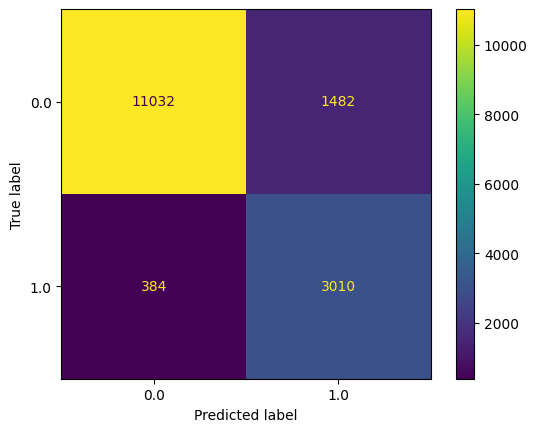

In [33]:
#Second Model RandomForest

from sklearn.ensemble import RandomForestClassifier

rf = Pipeline(steps=[
    ("preprocess",prepro),
    ("model",RandomForestClassifier(n_estimators=100,random_state=42,class_weight="balanced",n_jobs=-1))
     ])

rf.fit(X_train,y_train)

rf_ypred = rf.predict(X_test)
rf_yproba = rf.predict_proba(X_test)[:,1]

print(classification_report(y_test,y_pred))
print(f"\nROC_AUC RandomForest: ",roc_auc_score(y_test,y_proba))
print(confusion_matrix(y_test,y_pred))

cm = confusion_matrix(y_test,y_pred,)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = log_reg.classes_)
disp.plot()
plt.show()




***Now that both of our models are represented, we can safely notice that on this particular dataset with quantitative/qualitative data, both randomforest and logisticregression are equivalent***


***Let us move on to textual models, and were to use Tf-IDF thus bag of word for this one***

In [34]:
#columns with text

'''
The idea is to check for columns where the number of words is over 5-8, that shall discriminate categorical features and keep only textual ones
'''

for i in data.select_dtypes(include=["object","string"]):
    nb_mean_w = data[i].dropna().str.split().str.len().mean()
    print(i,nb_mean_w)



name 5.871195924401061
description 56.70835522216657
neighborhood_overview 71.41335858585859
host_name 1.1520169124925153
host_since 1.0
host_location 2.0212489291396403
host_about 51.54622907706216
host_response_time 3.3101434096036093
host_response_rate 1.0
host_acceptance_rate 1.0
host_neighbourhood 2.3169154939638545
host_verifications 1.9721383793824008
host_has_profile_pic 1.0
host_identity_verified 1.0
neighbourhood 2.0
neighbourhood_cleansed 1.0
property_type 3.1311741780997644
room_type 2.0
bathrooms_text 2.0854180422077127
amenities 51.20921652230218
has_availability 1.0
first_review 1.0
last_review 1.0
license 1.9311732743006642
instant_bookable 1.0


Here we may eexplore certain variables, such as, host_about, description,amenities,neighborhood_overview
Let us display a graph of those variables

In [35]:
text_col = ["description","host_about","amenities","neighborhood_overview"]
data_use[text_col]

,description,host_about,amenities,neighborhood_overview
0,This beautiful apartment is very well located ...,"I am living in Paris since 10 years, and I lov...","[""Wifi"", ""Hot water"", ""Heating"", ""Coffee maker...","The neighborhood is very nice, feel free to sh..."
1,"In the heart of historical Paris le Marais, gr...","I travel a lot for work and when I'm away, my ...","[""Paid parking on premises"", ""Wifi"", ""Free was...",Le Marais is the heart of Paris. Few years ago...
2,A stone's throw from Parc Monceau and the Arc ...,NaN,"[""Hair dryer"", ""Iron"", ""TV"", ""Heating"", ""Wifi""...",Quiet and residential area... Close to the Bat...
3,Cozy apartment close to everything.<br />Perfe...,"Jeune ingénieur, je propose mon appartement à ...","[""Elevator"", ""Hot water kettle"", ""Wifi"", ""Laun...",One of the most trendy corners of the capital ...
4,"Our apartment, refurbished by an architect in ...",NaN,"[""Elevator"", ""Wifi"", ""Self check-in"", ""Hot wat...",The apartment is in the heart of Paris's 18th ...
...,...,...,...,...
81847,The Konciergerie is delighted to offer you thi...,"Bienvenue à Paris ! \nJe suis Eliav, passionné...","[""Hot water kettle"", ""Wifi"", ""Babysitter recom...",NaN
81848,📌 Checkmyguest offers you a charming and spaci...,Checkmyguest est une entreprise de gestion loc...,"[""Elevator"", ""Hot water kettle"", ""Wifi"", ""Dini...",🏘️ The 8th arrondissement of Paris is one of t...
81849,The Konciergerie is proud to present this char...,"Bienvenue à Paris ! \nJe suis Eliav, passionné...","[""Hot water kettle"", ""Wifi"", ""Babysitter recom...",NaN
81851,Quiet 35 m2 apartment in the heart of Paris.<b...,"Mon appartement parisien est très cosy, décoré...","[""Wifi"", ""Laundromat nearby"", ""Freezer"", ""Self...",NaN


Amenities isn't good at all, it's just a list of items, so let us drop that one

['description', 'host_about', 'neighborhood_overview']


C:\Users\Yuan Shao\AppData\Local\Temp\ipykernel_4436\1075528311.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_use[cl + "n_words"] = (data_use[cl].fillna("").astype(str).str.split().str.len())
C:\Users\Yuan Shao\AppData\Local\Temp\ipykernel_4436\1075528311.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_use[cl + "n_words"] = (data_use[cl].fillna("").astype(str).str.split().str.len())
C:\Users\Yuan Shao\AppData\Local\Temp\ipykernel_4436\1075528311.py:7: SettingWithCopyWarning: 
A value is 

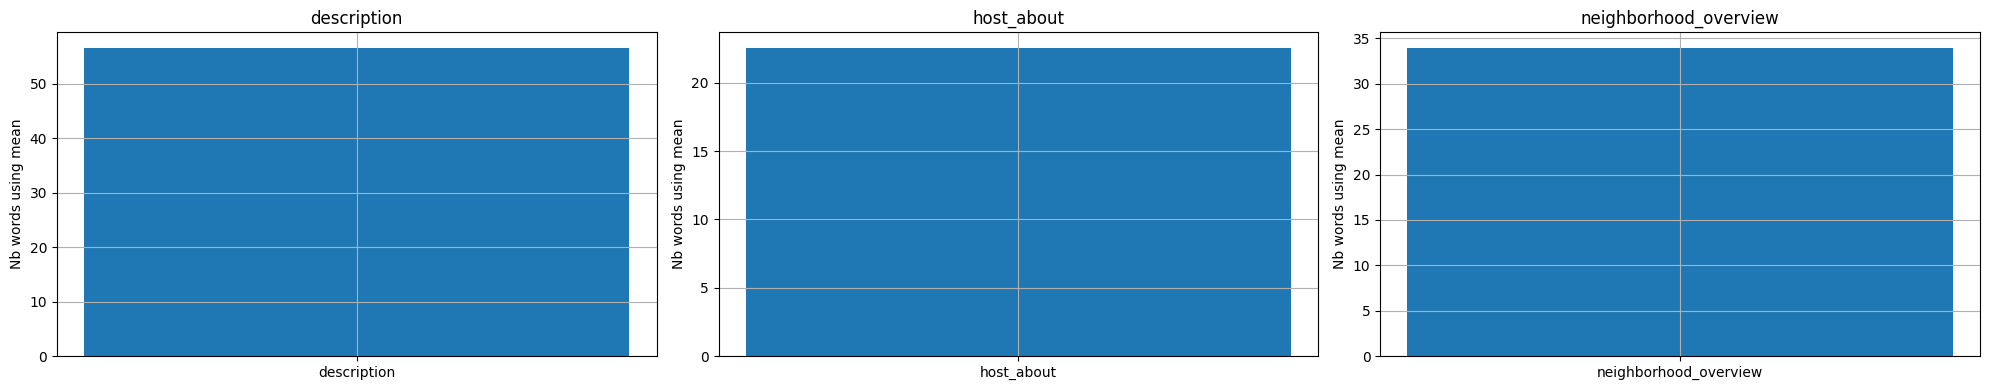

In [36]:
if "amenities" in text_col:
    text_col.remove("amenities")
print(text_col)
data_use[text_col]

for cl in text_col:
    data_use[cl + "n_words"] = (data_use[cl].fillna("").astype(str).str.split().str.len()) 

fig,axes = plt.subplots(1,len(text_col),figsize=(4*len(text_cols),4))

if len(text_col) == 1:
    axes = [axes]

for ax,cl in zip(axes,text_col):
    ax.bar(cl,data_use[cl + "n_words"].mean())
    ax.set_title(cl)
    ax.set_ylabel("Nb words using mean")
    ax.grid(True)

plt.tight_layout()
plt.show()









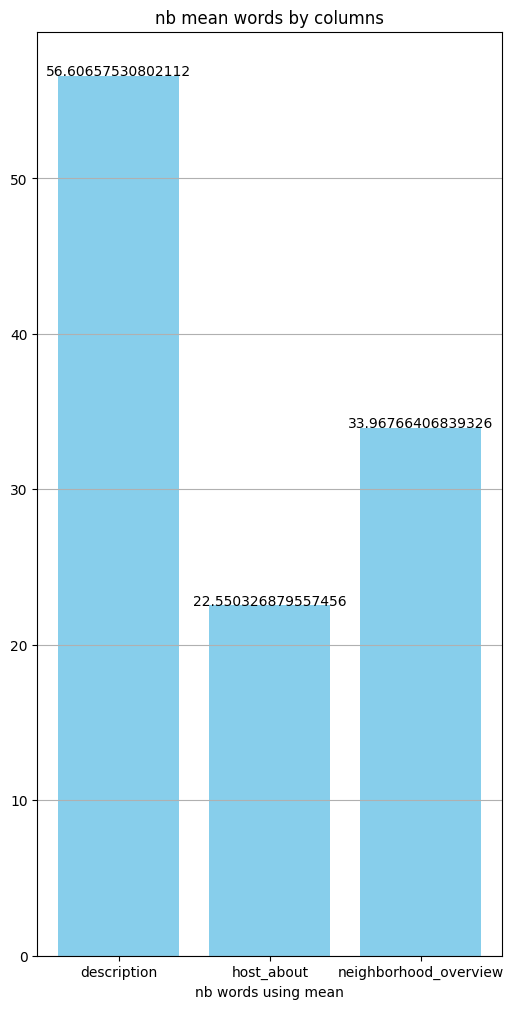

In [37]:
#for a better representation

mean_words = {cl : data_use[cl + "n_words"].mean() for cl in text_col}

plt.figure(figsize=(6,12))
plt.bar(mean_words.keys(),mean_words.values(),color='skyblue')
for i,v in enumerate(mean_words.values()):
    plt.text(i,v,str(v),ha="center")
plt.xlabel("nb words using mean")
plt.title("nb mean words by columns")
plt.grid(axis="y")
plt.show()




***As we may observe description has more words by comments than host_about and neighborhood_overview***

In [38]:
#let us start to create our pipeline

In [39]:
data["text"] = (data_use["description"].fillna("") + " " + data_use["host_about"].fillna("") + " " + data_use["name"].fillna(""))

In [40]:
data["text"]
#we grouped our columns into one because in NLP we dont work with several features at the same time, we regroup and use semantic to analyze our overall text

0        This beautiful apartment is very well located ...
1        In the heart of historical Paris le Marais, gr...
2        A stone's throw from Parc Monceau and the Arc ...
3        Cozy apartment close to everything.<br />Perfe...
4        Our apartment, refurbished by an architect in ...
                               ...                        
81848    📌 Checkmyguest offers you a charming and spaci...
81849    The Konciergerie is proud to present this char...
81850                                                  NaN
81851    Quiet 35 m2 apartment in the heart of Paris.<b...
81852    A newly renovated 3-room apartment designed to...
Name: text, Length: 81853, dtype: object

In [44]:
X_text = data["text"]

data = data.dropna(subset=["host_is_superhost"])

if data["host_is_superhost"].isna().sum() == 0:
    y = data[target]

print(y.isna().sum())

0


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)
#here we build the pipeline, and tfidf build a sparse matrix
pipeline_nlp = Pipeline([
    ("tfidf",TfidfVectorizer(max_features=20000,min_df=5,stop_words="english")),("clf",LogisticRegression(max_iter=1000,class_weight="balanced"))])
#training

pipeline_nlp.fit(X_train,y_train)
y_pred = pipeline_nlp.predict(X_test)
print(classification_report(y_pred,y_test))


              precision    recall  f1-score   support

         0.0       0.75      0.89      0.82     10629
         1.0       0.65      0.42      0.51      5279

    accuracy                           0.73     15908
   macro avg       0.70      0.65      0.66     15908
weighted avg       0.72      0.73      0.71     15908



***Excellent precision and recall, for class 0, however it is catastrophic for class 1, which means, at a threshold of 0.5, we accept more FP than FN, we must change the threshold,
we detect 80% of the true superhosts but for the precision 0.25 3/4 predictions are false, let us increase the threshold***

In [50]:
y_prob = pipeline_nlp.predict_proba(X_test)[:,1]
y_pred = (y_prob >= 0.65).astype(int)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88     13374
           1       0.42      0.57      0.48      2534

    accuracy                           0.81     15908
   macro avg       0.67      0.71      0.68     15908
weighted avg       0.83      0.81      0.82     15908



L’utilisation d’un classifieur 
Logistique avec TF-IDF et pondération des classes permet d’obtenir un compromis raisonnable, mais les performances restent limitées pour la prédiction du statut de superhost. Le seuil de décision influence fortement le compromis précision/rappel, sans toutefois dépasser un F1-score de 0.51 pour la classe minoritaire, suggérant que le texte seul n’est pas suffisant.

***Important step !***
***What in those words distinguish good hosts to bad ones ? And that is our next step INTERPRETABILITY***

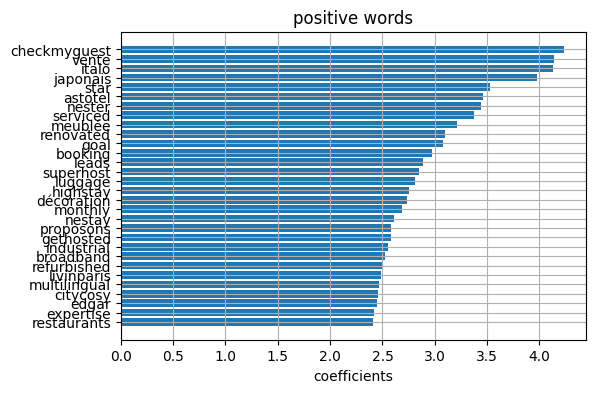

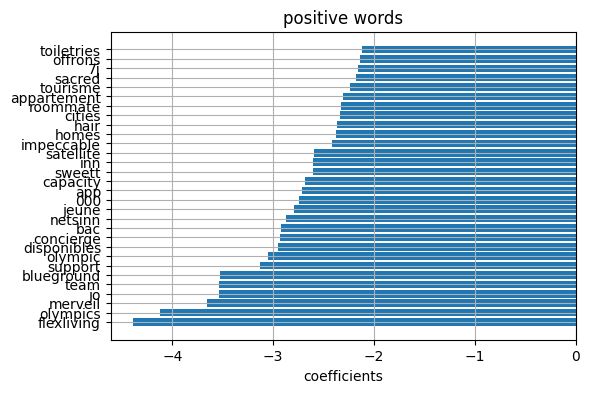

In [62]:
import numpy as np
tfidf = pipeline_nlp.named_steps["tfidf"]
clf = pipeline_nlp.named_steps["clf"]

feat_names : list = tfidf.get_feature_names_out()
feat_names #We do retrieve the words
coeffs = clf.coef_[0] #the weight of the word
coeffs

#Let us retrieve the most positive words for superhosts

pos_i_f = np.argsort(coeffs)[-30:]
pos_wordp = feat_names[pos_i_f]
pos_weightp = coeffs[pos_i_f]

#let us retrive the most negative words for superhosts

pos_i_s = np.argsort(coeffs)[:30]
pos_wordn = feat_names[pos_i_s]
pos_weightn = coeffs[pos_i_s]


#plots

plt.figure(figsize=(6,4))
plt.barh(pos_wordp,pos_weightp)
plt.title("positive words")
plt.xlabel("coefficients")
plt.grid(True)
plt.show()


#negative ones
plt.figure(figsize=(6,4))
plt.barh(pos_wordn,pos_weightn)
plt.title("negative words")
plt.xlabel("coefficients")
plt.grid(True)
plt.show()




***IMPORT TO TAKE INTO ACCOUNT !***
***We observe for superhosts that certains words thus nouns are used "renovated,expertise,citycosy,multilingual,checkmyguest(marketing),broadband", clearly qualitative words describing a certain quality of service.
However, regarding badhost "roomate,jeune,concierge,flexliving, clearly not the same standards***

***Those observations indicate that the sentences describing a superhost is focused on housing's quality, and for the badhost it is more focused on the "social" part***

In [64]:
#Second part with SVM
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)
#here we build the pipeline, and tfidf build a sparse matrix
pi_svm = Pipeline([
    ("tfidf",TfidfVectorizer(max_features=20000,min_df=5,stop_words="english")),("clf",LinearSVC(class_weight="balanced",max_iter=5000))])
#training

pi_svm.fit(X_train,y_train)
y_pred = pi_svm.predict(X_test)
print(classification_report(y_pred,y_test))

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' on line 8 (1264153494.py, line 9)